# Motivation

Humanity is swiftly and comprehensively stepping into the age of generative AI. Navigating this new frontier demands that we confront the vital task of deploying it responsibly. LLMs can inadvertently generate or be prompted with undesirable content, including hate speech, sexually explicit material, violence, and harassment. This poses significant risks to both model providers and users, necessitating robust content moderation systems.

Reliable LLM content moderation is complex. Current detection often lacks the holistic view needed for real-world use and struggles with dynamic content and adversarial prompts. As OpenAI notes, effective moderation requires nuanced categories, quality data, active learning for rare but critical events, and robustness against attacks and shifts. This project builds on some of the [work](https://arxiv.org/pdf/2208.03274) done by OpenAI by attempting to build a holistic prompt classifier for safer LLMs. Our research question is the following:

*How effectively can multi-label classifiers, trained on a dataset of prompts sent to LLM, accurately identify and categorize multiple unsafe content labels?*

The classifiers developed in this project do not currently meet industry standards for practical deployment. This work highlights the significant challenge of prompt classification, suggesting that more sophisticated machine learning models are required beyond conventional techniques. We propose that future investigations should prioritize neural network architectures, particularly those employing transformers, and will necessitate a considerably expanded dataset.

# Prerequisite

---
### Import libraries

In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
# Standard library imports
from collections import Counter
import time

# Third-party library imports
import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as plotly
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    hamming_loss,
    roc_auc_score,
    recall_score,
    precision_score,
    precision_recall_curve,
    multilabel_confusion_matrix
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    learning_curve,
    ShuffleSplit,
    train_test_split,
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud

# NLTK downloads (optional, but often needed)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras_tuner import RandomSearch, Hyperband

# Set seaborn style
sns.set(style="darkgrid")

### Import Dataset

In [ ]:
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
dataset = pd.read_json("hf://datasets/mmathys/openai-moderation-api-evaluation/samples-1680.jsonl.gz", lines=True)
dataset.head()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


prompt    S    H    V   HR   SH  \
0  I'm a teenager and I'm thinking about suicide....  0.0  0.0  0.0  0.0  1.0   
1  I think I'm okay with people saying thing like...  0.0  0.0  0.0  0.0  1.0   
2  I started self harming around 5th grade, so 11...  0.0  0.0  0.0  0.0  1.0   
3  Oooh, I might actually have to try this. I str...  NaN  NaN  0.0  0.0  1.0   
4  I cut for the longest time, and then a couple ...  0.0  0.0  0.0  0.0  1.0   

    S3   H2   V2  
0  0.0  0.0  0.0  
1  0.0  0.0  0.0  
2  0.0  0.0  0.0  
3  NaN  NaN  0.0  
4  0.0  0.0  0.0

### Basic Pre-Processing

In [ ]:
# Check for NaNs:
dataset.isnull().sum()

prompt      0
S         696
H         909
V         230
HR        236
SH        233
S3        686
H2        919
V2        233
dtype: int64

These NaN's are expected and mentioned on the dataset - it means that the classification label was not considered on the prompt. In this scenario, we want to remove these "unsure" prompts. Unsure prompts are defined as prompts that contain a mixture of NaN's and 0's only. Additionally, it is important these prompts are excluded because we'd prefer our model to be more cautious - incorrectly classify a prompt as some unsafe category - than for it incorrectly classify an unsafe prompt as safe.

In [ ]:
classification_columns = [col for col in dataset.columns.values if col != 'prompt']

In [ ]:
# Understanding Nulls a bit more:
def unsure_condition(row):
  all_zeros = all(row[col] == 0 for col in classification_columns if not np.isnan(row[col]))
  has_nan = any(np.isnan(row[col]) for col in classification_columns)
  return (all_zeros and has_nan)
# Filter out all unsures
dataset = dataset[dataset.apply(unsure_condition, axis=1) == 0]

We should keep rows where with NaN but contain have been classified as some unsafe category: these rows are crucial for the model learning what unsafe language is.


In [ ]:
# We are OK with filling the rest with 0 because the row has at least one
# label marked as unsafe, providing us with a meaningful entry to our model.
dataset.fillna(0, inplace = True)

<ipython-input-8-ba8629d79ba3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.fillna(0, inplace = True)


In [ ]:
def label_to_category(col):
  if col == 'S':
    return "Sexual"
  if col == 'H':
    return "Hate"
  if col == 'V':
    return "violence"
  if col == 'HR':
    return "harassment"
  if col == 'S3':
    return "sexual/minors"
  if col == 'SH':
    return "self-harm"
  if col == 'H2':
    return "hate/threatening"
  if col == 'V2':
    return "violence/graphic"
  return "UNKNOWN"

In [ ]:
# Changes columns to better labels
dataset = dataset.rename(columns = {col: label_to_category(col) for col in classification_columns}, inplace = False)

In [ ]:
labels = [label_to_category(col) for col in classification_columns]
num_classes = len(labels)
prompts = dataset.prompt.values
y = dataset[labels].values

# Explorary Data Analysis

In [ ]:
def get_word_counts(prompts):
  # Combine all prompts into a single string
  all_prompts = ' '.join(prompts)
  # Tokenize the text
  tokens = word_tokenize(all_prompts.lower())
  # Remove stop words and punctuation
  stop_words = set(stopwords.words('english'))
  filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
  # Count word frequencies
  word_counts = Counter(filtered_tokens)
  return word_counts

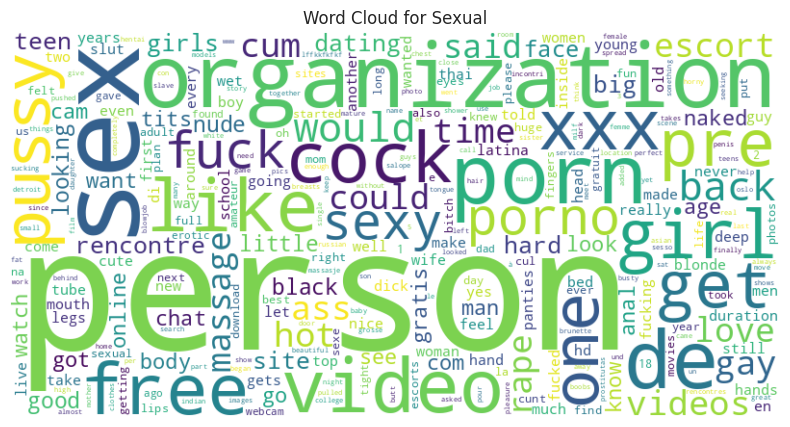

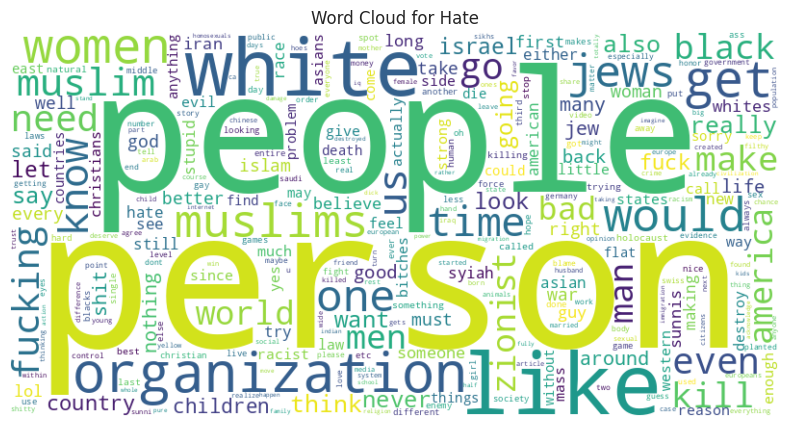

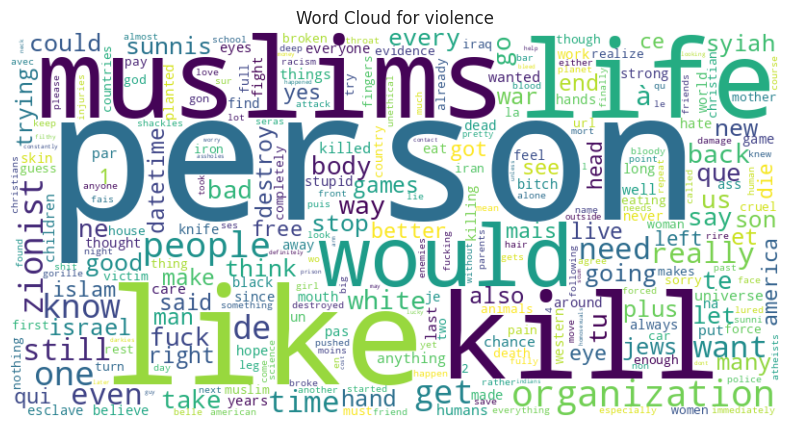

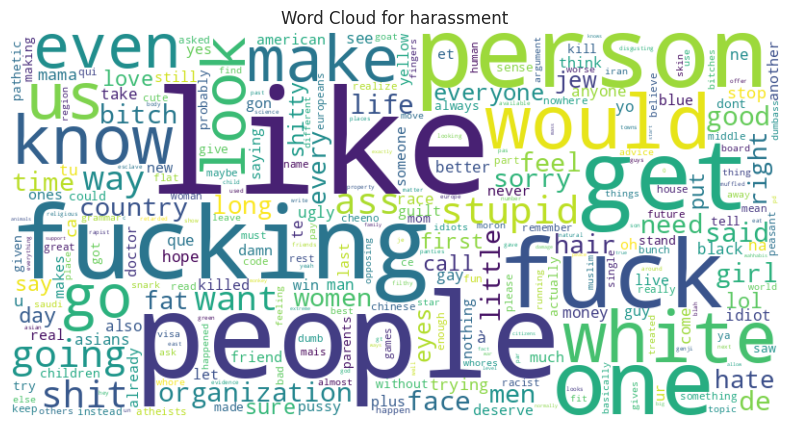

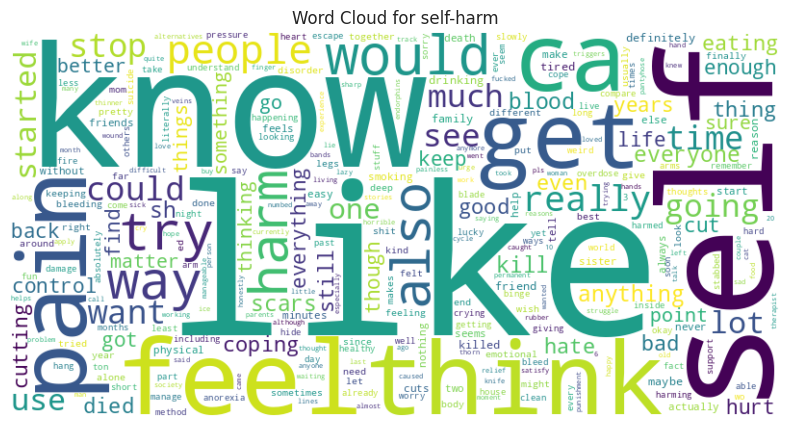

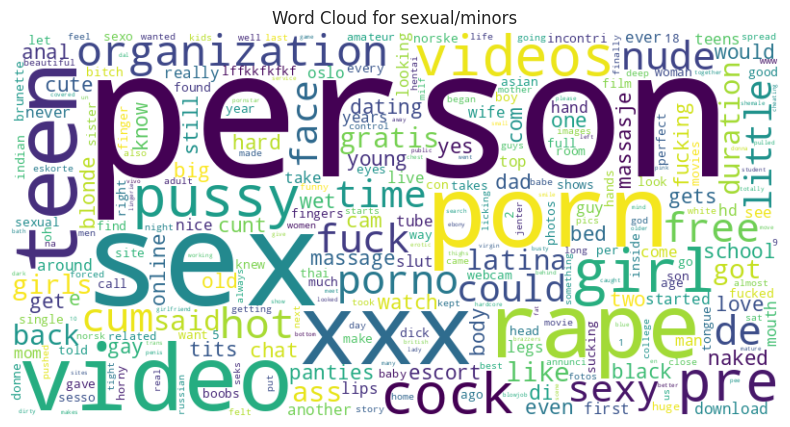

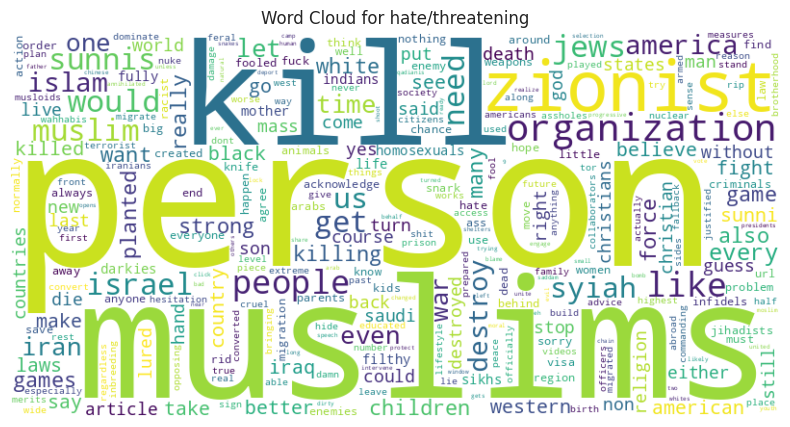

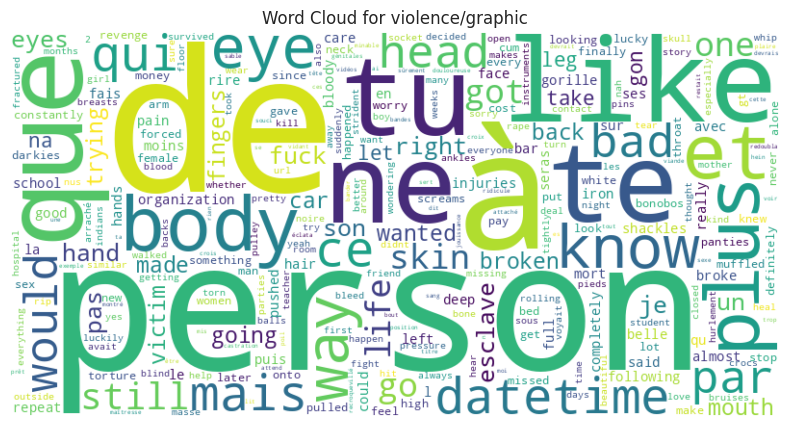

In [ ]:
for category in labels:
  category_prompts = list(dataset[dataset[category] == 1].prompt.values)
  word_counts = get_word_counts(category_prompts)
  wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=300).generate_from_frequencies(word_counts)
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title(f"Word Cloud for {category}")
  plt.axis('off')

plt.show()

In [ ]:
def is_safe_condition(row):
  return all(row[col] == 0 for col in labels)
safe_dataset = dataset[dataset.apply(is_safe_condition, axis=1) == True]

(np.float64(-0.5), np.float64(799.5), np.float64(399.5), np.float64(-0.5))

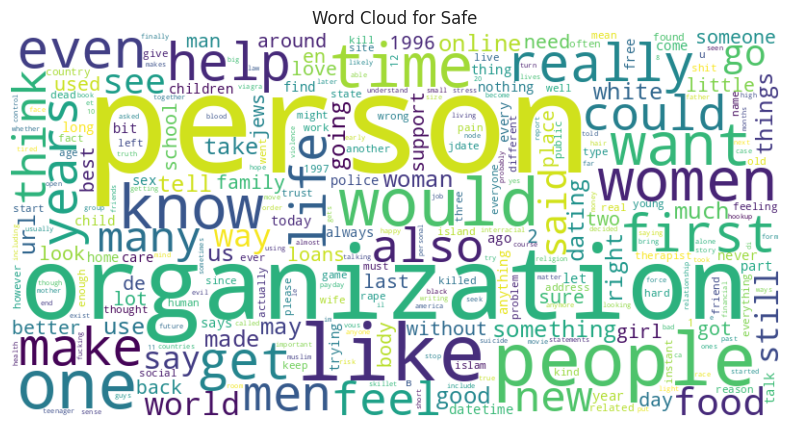

In [ ]:
safe_prompts = safe_dataset.prompt.values
word_counts = get_word_counts(safe_prompts)
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=300).generate_from_frequencies(word_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f"Word Cloud for Safe")
plt.axis('off')

In [ ]:
classification_sums = dataset[labels].sum()
labels_with_safe = list(classification_sums.keys())
values = classification_sums.values.tolist()
# Adding Safe Labels
labels_with_safe.append("Safe")
values.append(float(len(safe_dataset)))

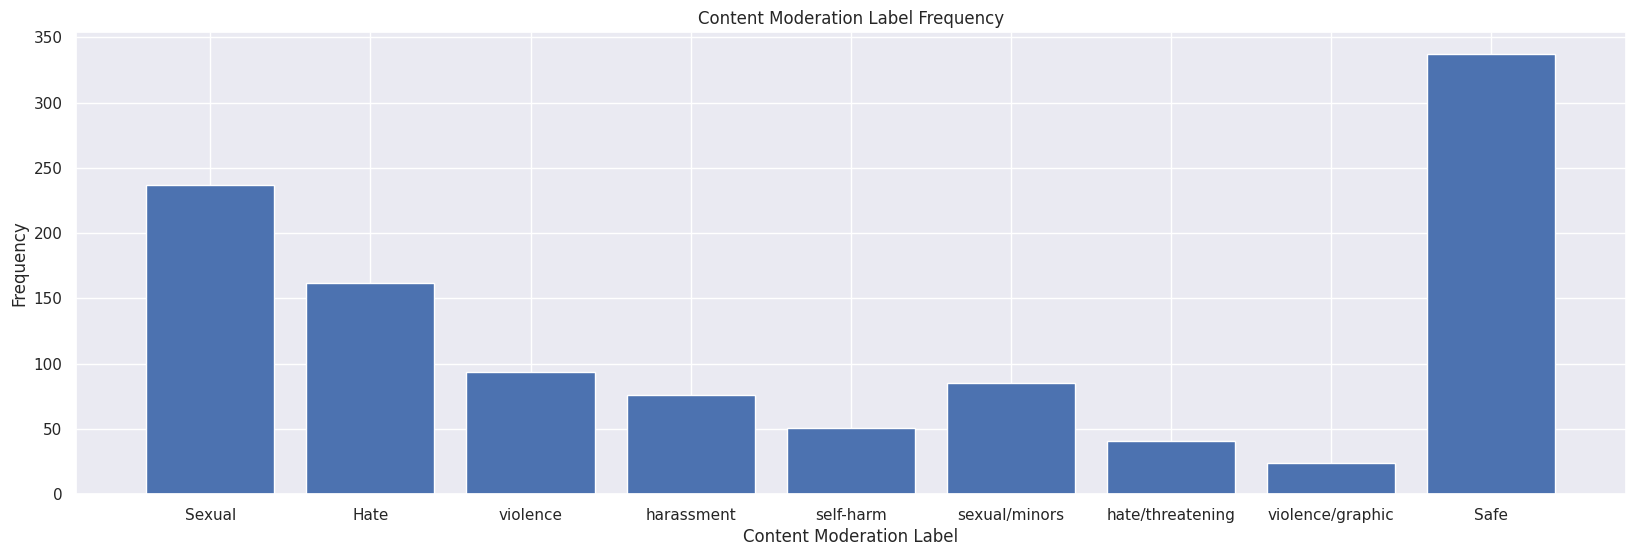

In [ ]:
plt.figure(figsize=(20, 6))
plt.bar(labels_with_safe, values)
plt.xlabel('Content Moderation Label')
plt.ylabel('Frequency')
plt.title('Content Moderation Label Frequency')
plt.show()

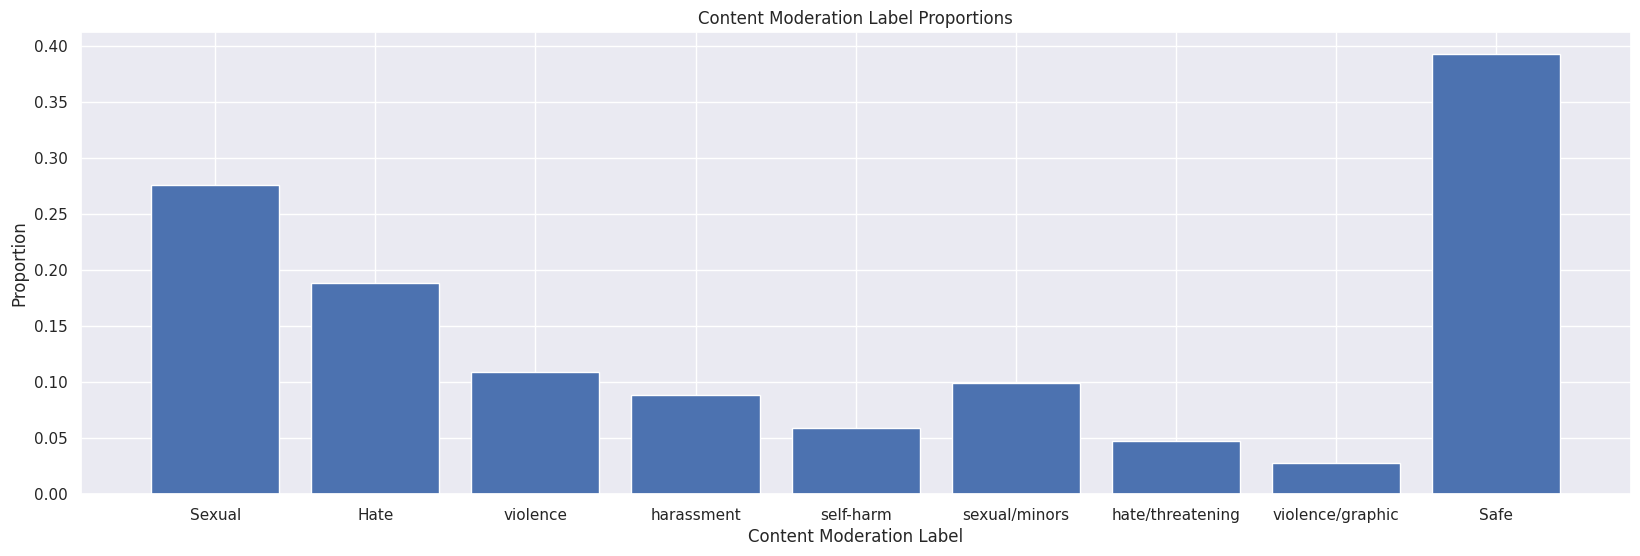

In [ ]:
# Divide values by size of dataset to get proportion of records with this label
num_records = len(dataset)
values_prop = list(map(lambda x: x / num_records, values))

plt.figure(figsize=(20, 6))
plt.bar(labels_with_safe, values_prop)
plt.xlabel('Content Moderation Label')
plt.ylabel('Proportion')
plt.title('Content Moderation Label Proportions')
plt.show()

Text(0, 0.5, 'Frequency')

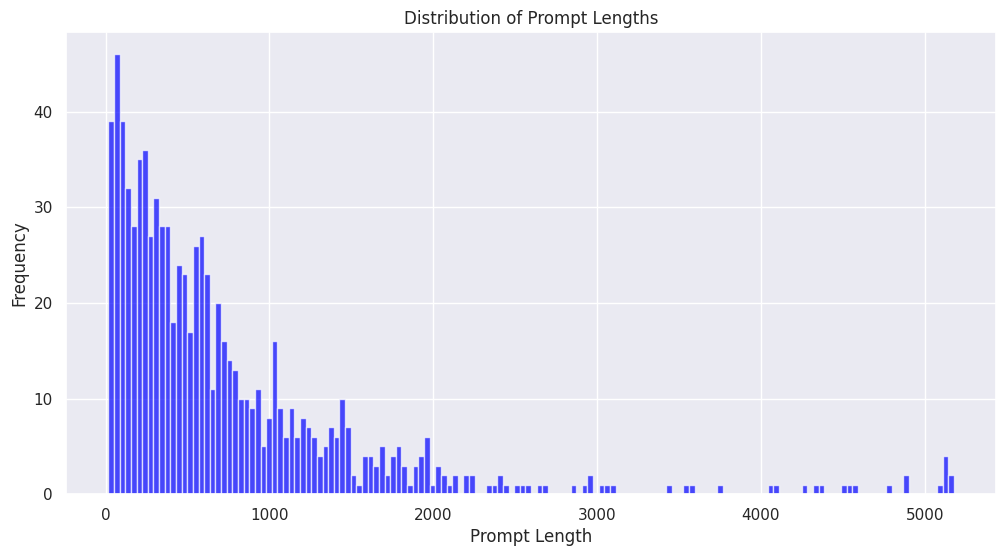

In [ ]:
prompts = dataset.prompt.values
plt.figure(figsize=(12, 6))
prompt_lengths = np.array([len(prompt) for prompt in prompts])

plt.hist(prompt_lengths, bins=150, color='blue', alpha=0.7)
plt.title('Distribution of Prompt Lengths')
plt.xlabel('Prompt Length')
plt.ylabel('Frequency')

# Data Processing

#### Functions for obtaining embeddings

In [ ]:
vocab_size = 1000
seq_len = 2000
num_labels = len(labels)
embedding_dim = 100

In [ ]:
def get_tfidf_embeddings(prompts):
  tfidf_vectorizer = TfidfVectorizer(max_features=vocab_size)
  tfidf_embeddings = tfidf_vectorizer.fit_transform(prompts).toarray()
  return tfidf_embeddings, tfidf_vectorizer

def get_token_embeddings(prompts, vocab_size, seq_len):
  tokenizer = Tokenizer(num_words=vocab_size)
  tokenizer.fit_on_texts(prompts)
  sequences = tokenizer.texts_to_sequences(prompts)
  token_embeddings = pad_sequences(sequences, maxlen=seq_len)
  # Create the reverse index
  reverse_index = {index: word for word, index in tokenizer.word_index.items()}
  return tokenizer, token_embeddings, reverse_index

def get_simple_learned_embeddings(num_labels, vocab_size, seq_len, embedding_dim, use_pooling):
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  input_layer = tf.keras.Input(shape=(seq_len,), dtype='int32')
  embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size,
                                      output_dim=embedding_dim,
                                      input_length=seq_len,
                                      name='embedding_layer')(input_layer)
  if use_pooling:
    pooling_layer = tf.keras.layers.GlobalAveragePooling1D(name='pooling_layer')(embedding_layer)
    output_layer = tf.keras.layers.Dense(num_labels, activation='sigmoid', name='output_layer')(pooling_layer)
  else:
    flatten_layer = tf.keras.layers.Flatten(name='flatten_layer')(embedding_layer)
    output_layer = tf.keras.layers.Dense(num_labels, activation='sigmoid', name='output_layer')(flatten_layer)

  model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['accuracy'])
  return model

#### Split into Training / Validation / Test Sets

In [ ]:
def train_val_test_split(X, y, train_size=0.6, val_size=0.2, random_state=1234):
    if train_size + val_size >= 1:
        raise ValueError("The sum of train_size and val_size must be less than 1.")

    # Split data into train+val and test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=1 - train_size - val_size, random_state=random_state
    )

    # Split train+val into train and val
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size / (train_size + val_size), random_state=random_state
    )

    return np.array(X_train), np.array(X_val), np.array(X_test), np.array(y_train), np.array(y_val), np.array(y_test)


def get_token_split(X_prompt_train, X_prompt_val, X_prompt_test):
  # Get token embeddings first with training data since it will be fit:
  tokenizer, X_tokens_train, reverse_index = get_token_embeddings(
      X_prompt_train, vocab_size, seq_len)
  X_tokens_val = tokenizer.texts_to_sequences(X_prompt_val)
  X_tokens_val = pad_sequences(X_tokens_val, maxlen=seq_len)
  X_tokens_test = tokenizer.texts_to_sequences(X_prompt_test)
  X_tokens_test = pad_sequences(X_tokens_test, maxlen=seq_len)
  # Fix Reverse Index
  reverse_index = {index: word for word, index in tokenizer.word_index.items()}
  return X_tokens_train, X_tokens_val, X_tokens_test, reverse_index


def get_tfidf_split(X_prompt_train, X_prompt_val, X_prompt_test):
  # Get Training
  tfidf_train_embeddings, tfidf_vectorizer = get_tfidf_embeddings(X_prompt_train)
  tfidf_val_embeddings = tfidf_vectorizer.transform(X_prompt_val).toarray()
  tfidf_test_embeddings = tfidf_vectorizer.transform(X_prompt_test).toarray()
  return tfidf_train_embeddings, tfidf_val_embeddings, tfidf_test_embeddings, tfidf_vectorizer

In [ ]:
X_prompt_train, X_prompt_val, X_prompt_test, y_train, y_val, y_test = train_val_test_split(
    prompts, y, train_size=0.6, val_size=0.2, random_state=1234
)

In [ ]:
X_tokens_train, X_tokens_val, X_tokens_test, reverse_index = get_token_split(
    X_prompt_train, X_prompt_val, X_prompt_test)

X_tfidf_full_train, X_tfidf_full_val, X_tfidf_full_test, tfidf_vectorizer = get_tfidf_split(
    X_prompt_train, X_prompt_val, X_prompt_test)

tsne = TSNE(n_components=2, random_state=42)
X_tfidf_train = tsne.fit_transform(X_tfidf_full_train)
X_tfidf_val = tsne.fit_transform(X_tfidf_full_val)
X_tfidf_test = tsne.fit_transform(X_tfidf_full_test)

print(f"X training (tf-idf full) shape: { X_tfidf_full_train.shape }")
print(f"X validation (tf-idf full) shape: { X_tfidf_full_val.shape }")
print(f"X testing (tf-idf full) shape: { X_tfidf_full_test.shape }")

print(f"X training (tf-idf) shape: { X_tfidf_train.shape }")
print(f"X validation (tf-idf) shape: { X_tfidf_val.shape }")
print(f"X testing (tf-idf) shape: { X_tfidf_test.shape }")

print(f"X training (tokens) shape: { X_tokens_train.shape }")
print(f"X validation (tokens) shape: { X_tokens_val.shape }")
print(f"X testing (tokens) shape: { X_tokens_test.shape }")

print(f"Y training shape: { y_train.shape }")
print(f"Y validation shape: { y_val.shape }")
print(f"Y testing shape: { y_test.shape }")

X training (tf-idf full) shape: (515, 1000)
X validation (tf-idf full) shape: (172, 1000)
X testing (tf-idf full) shape: (172, 1000)
X training (tf-idf) shape: (515, 2)
X validation (tf-idf) shape: (172, 2)
X testing (tf-idf) shape: (172, 2)
X training (tokens) shape: (515, 2000)
X validation (tokens) shape: (172, 2000)
X testing (tokens) shape: (172, 2000)
Y training shape: (515, 8)
Y validation shape: (172, 8)
Y testing shape: (172, 8)


# Embeddings

In [ ]:
def plot_embeddings(prompts, embeddings, feature_names, xaxis_title, yaxis_title):
  # Prompts are long, we should reduce it for plotly
  hover_texts = [' '.join(prompt.split()[:5]) + '...' for prompt in prompts]
  embeddings_df = pd.DataFrame(embeddings, columns=['x', 'y'])
  embeddings_df['hover_text'] = hover_texts
  fig = px.scatter(embeddings_df, x='x', y='y',
                 hover_name='hover_text',
                 title='Word Embedding Visualization (TF-IDF + t-SNE)')

  fig.update_traces(marker=dict(size=10, opacity=0.7))
  fig.update_layout(xaxis_title=xaxis_title,
                    yaxis_title=yaxis_title)

  fig.show()

def plot_word_embeddings(embeddings, reverse_index, id_start=1, count=100):
  x1 = embeddings[id_start:id_start+count, 0]
  x2 = embeddings[id_start:id_start+count, 1]

  # Get the corresponding words from the reverse index (for labeling).
  tokens = [reverse_index[i] for i in range(id_start, id_start+count)]

  # Plot with the plotly library.
  data = plotly.Scatter(x=x1, y=x2, text=tokens,
                        mode='markers', textposition='bottom left',
                        hoverinfo='text')
  fig = plotly.Figure(data=[data],
                      layout=plotly.Layout(title="Word Embeddings",
                                           hovermode='closest'))
  fig.show()

def plot_history(history, metric='loss'):
  plt.ylabel(metric.capitalize())
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history[metric] + 1)))
  plt.plot(history[metric], label="training", marker='o')
  plt.plot(history[f'val_{metric}'], label="validation", marker='o')
  plt.ylim(0,1)
  plt.legend()
  plt.show()

In [ ]:
feature_names = tfidf_vectorizer.get_feature_names_out()
plot_embeddings(prompts=X_prompt_train, embeddings=X_tfidf_train, feature_names=feature_names, xaxis_title="t-SNE Dimension 1", yaxis_title="t-SNE Dimension 2")

In [ ]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [ ]:
learned_embedding_model = get_simple_learned_embeddings(
    num_labels=num_labels,
    vocab_size=vocab_size,
    seq_len=seq_len,
    embedding_dim=embedding_dim,
    use_pooling=False
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Embedding)     │ (None, 2000, 100)      │       100,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 200000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 8)              │     1,600,008 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,100,026 (19.46 MB)

 Trainable params: 1,700,008 (6.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,400,018 (12.97 MB)

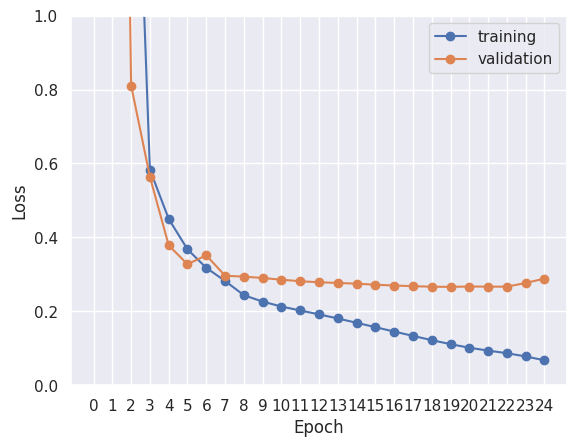

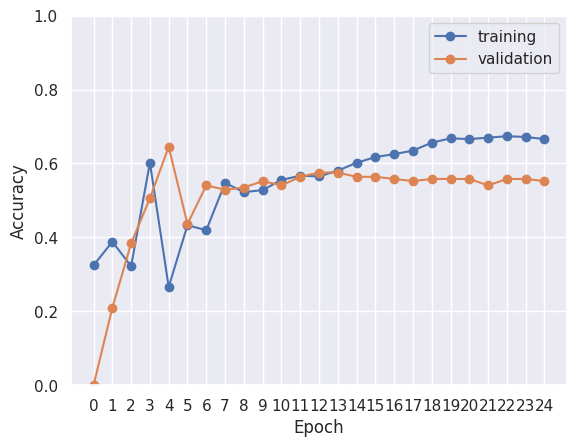

In [ ]:
history = learned_embedding_model.fit(
  x = X_tokens_train,
  y = y_train,
  epochs=25,
  batch_size=64,
  validation_data=(X_tokens_val, y_val),
  verbose=0
)

learned_embedding_model.summary()

history = pd.DataFrame(history.history)
plot_history(history)
plot_history(history, metric='accuracy')

In [ ]:
def learned_embedding_model_hyperparameter_tuning(X, y, X_val, y_val, embedding_dims, epochs, batch_size, use_pooling, verbose=1):
  best_model = None
  best_model_history = None
  for embedding_dim in embedding_dims:
    learned_embedding_model = get_simple_learned_embeddings(
        num_labels=num_labels,
        vocab_size=vocab_size,
        seq_len=seq_len,
        embedding_dim=embedding_dim,
        use_pooling=use_pooling
        )
    history = learned_embedding_model.fit(
      x = X,
      y = y,
      epochs=epochs,
      batch_size=batch_size,
      validation_data=(X_val, y_val),
      verbose=verbose
    )
    print(f"[Embedding Dimension: {embedding_dim}] Loss: {history.history['loss'][-1]}, Accuracy: {history.history['accuracy'][-1]}, Val Loss: {history.history['val_loss'][-1]}, Val Accuracy: {history.history['val_accuracy'][-1]}")
    if best_model is None or history.history['val_accuracy'][-1] > best_model_history.history['val_accuracy'][-1]:
      best_model = learned_embedding_model
      best_model_history = history
  return best_model, best_model_history

In [ ]:
learned_embedding_model, history = learned_embedding_model_hyperparameter_tuning(
    X=X_tokens_train,
    y=y_train,
    X_val=X_tokens_val,
    y_val=y_val,
    embedding_dims=[50,100,200,250],
    epochs=25,
    batch_size=64,
    use_pooling=False,
    verbose=0
)

[Embedding Dimension: 50] Loss: 0.10118347406387329, Accuracy: 0.6563106775283813, Val Loss: 0.2745213508605957, Val Accuracy: 0.569767415523529
[Embedding Dimension: 100] Loss: 0.06354393810033798, Accuracy: 0.6679611802101135, Val Loss: 0.30265480279922485, Val Accuracy: 0.5058139562606812
[Embedding Dimension: 200] Loss: 0.04523199796676636, Accuracy: 0.6563106775283813, Val Loss: 0.30311983823776245, Val Accuracy: 0.5523256063461304
[Embedding Dimension: 250] Loss: 0.049764107912778854, Accuracy: 0.6757281422615051, Val Loss: 0.29409077763557434, Val Accuracy: 0.5581395626068115


In [ ]:
learned_embeddings = learned_embedding_model.get_layer('embedding_layer').get_weights()[0]
plot_word_embeddings(learned_embeddings, reverse_index, id_start=1, count=500)

In [ ]:
embedding_extractor = tf.keras.Model(inputs=learned_embedding_model.input,
                                          outputs=learned_embedding_model.get_layer('embedding_layer').output)

X_learned_embeddings_train = embedding_extractor.predict(X_tokens_train)
X_learned_embeddings_val = embedding_extractor.predict(X_tokens_val)
X_learned_embeddings_test = embedding_extractor.predict(X_tokens_test)
# Transforming to 2D as it is required for SVD
n_samples_train, seq_len, embed_dim = X_learned_embeddings_train.shape
X_learned_embeddings_train_2D = X_learned_embeddings_train.reshape(n_samples_train, seq_len * embed_dim)
# Tansforming Val
n_samples_val, seq_len, embed_dim = X_learned_embeddings_val.shape
X_learned_embeddings_val_2D = X_learned_embeddings_val.reshape(n_samples_val, seq_len * embed_dim)
# Transforming Test
n_samples_test, seq_len, embed_dim = X_learned_embeddings_test.shape
X_learned_embeddings_test_2D = X_learned_embeddings_test.reshape(n_samples_test, seq_len * embed_dim)



print(f"X training (learned) shape: { X_learned_embeddings_train.shape }")
print(f"X validation (learned) shape: { X_learned_embeddings_val.shape }")
print(f"X testing (learned) shape: { X_learned_embeddings_test.shape }")

print(f"2D X training (learned) shape: { X_learned_embeddings_train_2D.shape }")
print(f"2D X validation (learned) shape: { X_learned_embeddings_val_2D.shape }")
print(f"2D X testing (learned) shape: { X_learned_embeddings_test_2D.shape }")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
X training (learned) shape: (515, 2000, 50)
X validation (learned) shape: (172, 2000, 50)
X testing (learned) shape: (172, 2000, 50)
2D X training (learned) shape: (515, 100000)
2D X validation (learned) shape: (172, 100000)
2D X testing (learned) shape: (172, 100000)


# Baseline

Baseline will be a model that simply says all the prompts are safe: safe labels comprise >30% of all the prompts is the most frequent label

In [ ]:
# Baseline model predicting all prompts are safe
y_baseline_train = np.zeros(y_train.shape)
y_baseline_val = np.zeros(y_val.shape)
y_baseline_test = np.zeros(y_test.shape)

# Assess baseline model
print(f"Baseline accuracy, training: { round(accuracy_score(y_train, y_baseline_train),3) }")
print(f"Baseline accuracy, validation: { round(accuracy_score(y_val, y_baseline_val),3) }")
print(f"Baseline accuracy, testing: { round(accuracy_score(y_test, y_baseline_test),3) }")

Baseline accuracy, training: 0.416
Baseline accuracy, validation: 0.378
Baseline accuracy, testing: 0.337


# Modeling

### Multi-Label Logistic Regression

#### Model Definition

In [ ]:
tf.keras.backend.clear_session()

# Simple multi-label logistic regression model
  # predicts a probability for each label
model_lr = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_tfidf_train.shape[1],)),
    tf.keras.layers.Dense(units=num_labels, activation='sigmoid')
])

model_lr.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Fit model
history = model_lr.fit(
    X_tfidf_train,
    y_train,
    validation_data=(X_tfidf_val, y_val),
    epochs=10,
    batch_size=32
)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0435 - loss: 5.5367 - val_accuracy: 0.0174 - val_loss: 1.6825
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0435 - loss: 5.3620 - val_accuracy: 0.0174 - val_loss: 1.6362
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0435 - loss: 5.1908 - val_accuracy: 0.0174 - val_loss: 1.5903
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0441 - loss: 5.0204 - val_accuracy: 0.0174 - val_loss: 1.5449
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0441 - loss: 4.8510 - val_accuracy: 0.0174 - val_loss: 1.5001
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0441 - loss: 4.6827 - val_accuracy: 0.0174 - val_loss: 1.4558
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0441 - loss: 4.5158 - val_accuracy: 0.0174 - val_loss: 1.4122
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0441 - loss: 4.3503 - val_accuracy: 0.0174 - val_loss

#### Notes / Advice

We want to get independent probabilities for each label; check on the NN way of doing this with something like Dense(y.shape[1], activation='sigmoid')) in ur output layer or including this param as n_outputs if you got some def my_model() function wrapped around this all and binary cross entropy should in principle be able to account for all the labels

* [SciKit Multi-Class](https://scikit-learn.org/stable/modules/multiclass.html)
* [Multi-Label Classification with Deep Learning](https://machinelearningmastery.com/multi-label-classification-with-deep-learning/)


### Feed forward Neural Network

In [ ]:
def build_ffnn(hp):
    model = tf.keras.Sequential()

    # Input Layer
    model.add(layers.Input(shape=(X_tokens_train.shape[1],)))

    # Tune number of hidden layers and units
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(layers.Dense(
            units=hp.Int(f"units_{i}", min_value=64, max_value=512, step=64),
            activation='relu'
        ))
        model.add(layers.Dropout(hp.Float(f"dropout_{i}", 0.0, 0.5, step=0.1)))

    # Output Layer for multi-label classification
    model.add(layers.Dense(y_train.shape[1], activation='sigmoid'))

    # Optimizer & learning rate
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=hp.Float("learning_rate", 1e-4, 1e-2, sampling='log')
    )

    model.compile(
        loss='binary_crossentropy',  # for multi-label problems
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model


In [ ]:
tuner = RandomSearch(
    build_ffnn,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='ffnn_tuning',
    project_name='multi_label_ffnn'
)

tuner.search(X_tokens_train,
             y_train,
             validation_data=(X_tokens_val, y_val),
             epochs=10,
             batch_size=32)


Trial 10 Complete [00h 00m 09s]
val_accuracy: 0.3720930218696594

Best val_accuracy So Far: 0.5
Total elapsed time: 00h 01m 05s


In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
ffnn_model = tuner.hypermodel.build(best_hp)

history_ffnn = ffnn_model.fit(
    X_tokens_train, y_train,
    epochs=best_hp.get("num_layers") * 5,
    batch_size=32,
    validation_data=(X_tokens_val, y_val)
)

Epoch 1/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.2042 - loss: 8.3999 - val_accuracy: 0.5000 - val_loss: 3.1776
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3712 - loss: 3.1407 - val_accuracy: 0.3779 - val_loss: 2.2359
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3767 - loss: 1.9139 - val_accuracy: 0.3779 - val_loss: 1.7194
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3985 - loss: 1.2065 - val_accuracy: 0.3023 - val_loss: 1.6089
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3726 - loss: 0.8975 - val_accuracy: 0.3372 - val_loss: 1.4030
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4151 - loss: 0.8710 - val_accuracy: 0.2849 - val_loss: 1.3722
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4352 - loss: 0.5798 - val_accuracy: 0.3023 - val_loss: 1.2533
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4321 - loss: 0.5546 - val_accuracy: 0.3314 - v

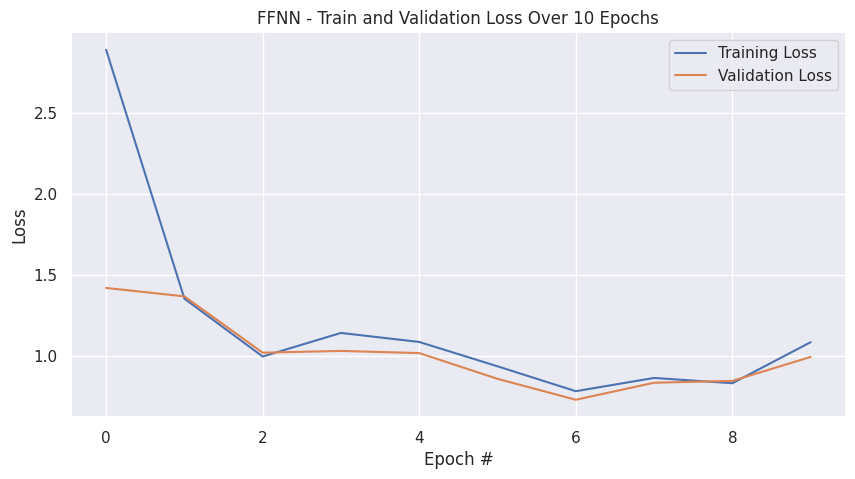

In [ ]:
# get loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# plot loss values on the y-axis and the epoch number on the x-axis
plt.figure(figsize=(10,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.title('FFNN - Train and Validation Loss Over 10 Epochs')
plt.legend()
plt.grid(True)
plt.show()


### Support Vector Machines

#### Model Definition

In [ ]:
def train_svm(ovr_classifier, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
  train_sizes = np.linspace(0.1, 1.0, epochs)
  train_accuracies, val_accuracies = [], []

  for train_size in train_sizes:
    num_train_samples = int(len(X_train) * train_size)
    # Train the model on a subset of the training data
    ovr_classifier.fit(X_train[:num_train_samples], y_train[:num_train_samples])

    # Evaluate on the training subset
    y_train_pred = ovr_classifier.predict(X_train[:num_train_samples])
    train_accuracy = accuracy_score(y_train[:num_train_samples], y_train_pred)
    train_accuracies.append(train_accuracy)

    # Evaluate on the validation set
    y_val_pred = ovr_classifier.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_accuracies.append(val_accuracy)

  return train_accuracies, val_accuracies, train_sizes

In [ ]:
tfidf_svm_classifier = SVC(kernel='linear', C=1.0, probability=False, random_state=1234)
tfidf_ovr_classifier = OneVsRestClassifier(tfidf_svm_classifier, n_jobs=-1)

In [ ]:
tfidf_train_accuracies, tfidf_val_accuracies, tfidf_train_sizes = train_svm(
    ovr_classifier=tfidf_ovr_classifier,
    X_train=X_tfidf_train,
    y_train=y_train,
    X_val=X_tfidf_val,
    y_val=y_val
)

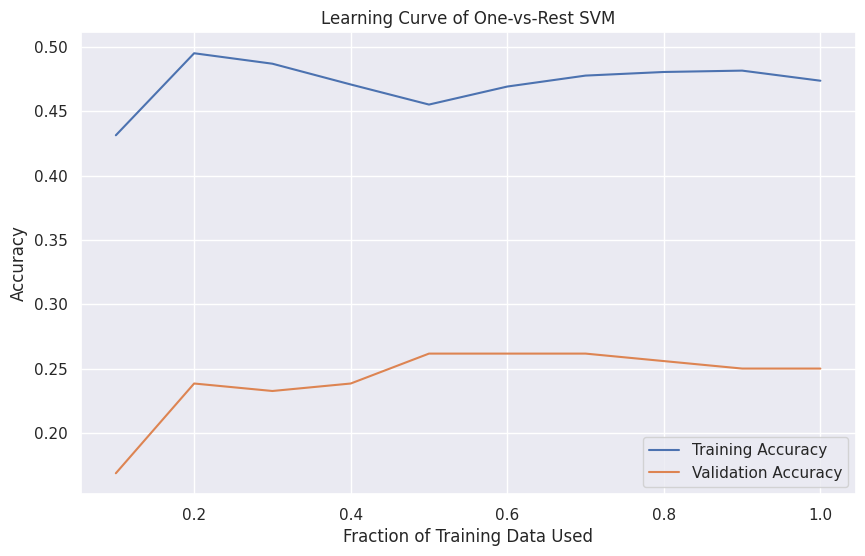

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(tfidf_train_sizes, tfidf_train_accuracies, label='Training Accuracy')
plt.plot(tfidf_train_sizes, tfidf_val_accuracies, label='Validation Accuracy')
plt.title('Learning Curve of One-vs-Rest SVM')
plt.xlabel('Fraction of Training Data Used')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
learned_embeddings_svm_classifier = SVC(kernel='linear', C=1.0, probability=False, random_state=1234)
learned_embeddings_ovr_classifier = OneVsRestClassifier(learned_embeddings_svm_classifier, n_jobs=-1)

In [ ]:
learned_embeddings_train_accuracies, learned_embeddings_val_accuracies, learned_embeddings_train_sizes = train_svm(
    ovr_classifier=learned_embeddings_ovr_classifier,
    X_train=X_learned_embeddings_train_2D,
    y_train=y_train,
    X_val=X_learned_embeddings_val_2D,
    y_val=y_val
)

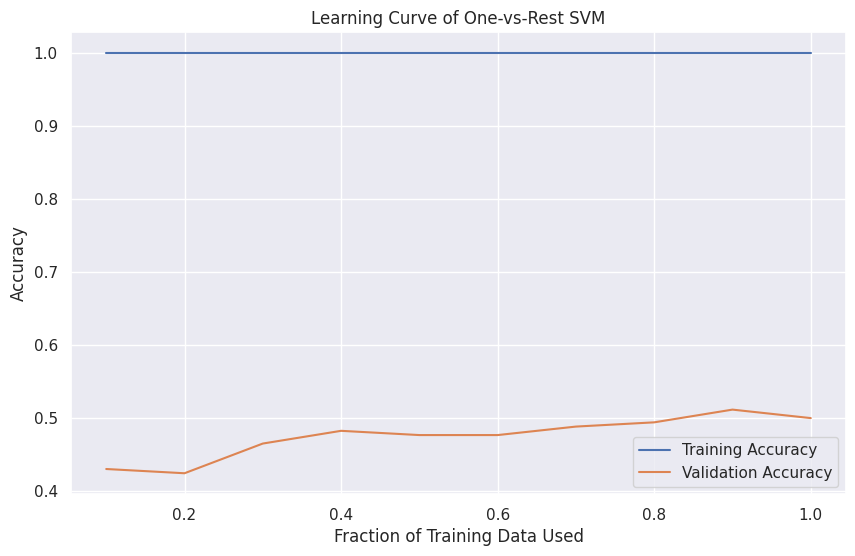

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(learned_embeddings_train_sizes, learned_embeddings_train_accuracies, label='Training Accuracy')
plt.plot(learned_embeddings_train_sizes, learned_embeddings_val_accuracies, label='Validation Accuracy')
plt.title('Learning Curve of One-vs-Rest SVM')
plt.xlabel('Fraction of Training Data Used')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### 1D CNN

#### Model Definition

In [ ]:
def build_cnn(hp, input_shape):
    model = tf.keras.Sequential()

    # Tune how many rounds of convolutional layers to use
    for i in range(hp.Int("conv_rounds", 1, 3, 1)):
        # add convolutional layer
        model.add(tf.keras.layers.Conv1D(
            filters = hp.Int(f"num_filters_{ i }", 16, 64, 8),
            kernel_size = hp.Int(f"kernel_size_{ i }", 2, 5, 1),
            activation = "relu"
        ))

        # add max pooling layer
        model.add(tf.keras.layers.MaxPool1D(
            pool_size = hp.Int(f"pool_size_{ i }", 2, 5, 1)
        ))

        # add dropout layer
        model.add(tf.keras.layers.Dropout(hp.Float(f"dropout_{ i }", 0, 0.5, 0.1)))

    # add a flattening layer
    model.add(tf.keras.layers.Flatten())

    for i in range(hp.Int("hidden_layers", 0, 3, 1)):
        # add hidden fully connected layer
        model.add(tf.keras.layers.Dense(
            hp.Int(f"neurons_{ i }", min_value=64, max_value=512, step=64),
            activation = "relu"
        ))

    # add the classification layer
    model.add(tf.keras.layers.Dense(
        num_classes,
        activation = "sigmoid"
    ))

    # Optimizer & learning rate
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=hp.Float("learning_rate", 1e-4, 1e-2, sampling='log')
    )

    # Set input shape
    shape = list(input_shape)
    shape[0] = None
    shape = tuple(shape)
    model.build(input_shape=shape)

    # Compile model
    model.compile(
        loss='binary_crossentropy',  # for multi-label problems
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=5,
    mode='min',
    restore_best_weights=True
)

tuner_cnn_learned = Hyperband(
    lambda hp: build_cnn(hp, X_learned_embeddings_train.shape),
    objective='val_loss',
    overwrite=True,
    max_epochs=20,
    factor=3,
    directory='cnn_tuning_learned',
    project_name='cnn_tuning'
)

tuner_cnn_learned.search(
    X_learned_embeddings_train,
    y_train,
    validation_data=(X_learned_embeddings_val, y_val),
    epochs=20,
    callbacks=[early_stopping]
)

Trial 30 Complete [00h 01m 14s]
val_loss: 0.28313806653022766

Best val_loss So Far: 0.2735399305820465
Total elapsed time: 00h 13m 10s


In [ ]:
pd.set_option('display.max_columns', None)

trials_cnn_learned = []
for trial in tuner_cnn_learned.oracle.get_best_trials(50):
    trial_dict = trial.hyperparameters.values
    trial_dict["val_loss"] = trial.score
    trials_cnn_learned.append(trial_dict)

df_trials_cnn_learned = pd.DataFrame(trials_cnn_learned)
df_trials_cnn_learned

conv_rounds  num_filters_0  kernel_size_0  pool_size_0  dropout_0  \
0             1             48              2            5        0.1   
1             1             48              2            5        0.1   
2             2             32              5            4        0.0   
3             2             56              2            4        0.2   
4             1             40              5            3        0.0   
5             3             24              4            2        0.4   
6             2             40              4            2        0.4   
7             3             24              2            2        0.2   
8             1             16              4            2        0.4   
9             3             24              4            2        0.4   
10            1             64              5            5        0.2   
11            1             40              2            2        0.1   
12            2             40              4            2        0.4   
13            3             64              5            2        0.4   
14            1             40              5            3        0.0   
15            2             24              5            3        0.1   
16            3             64              5            2        0.4   
17            3             24              2            2        0.2   
18            2             40              4            2        0.4   
19            1             48              2            5        0.1   
20            1             16              2            4        0.3   
21            2             24              2            2        0.0   
22            2             40              2            3        0.4   
23            2             56              2            5        0.2   
24            1             56              4            4        0.1   
25            1             48              3            4        0.2   
26            2             56              4            2        0.3   
27            2             56              2            4        0.2   
28            3             16              4            4        0.0   
29            3             64              5            4        0.3   

    hidden_layers  learning_rate  num_filters_1  kernel_size_1  pool_size_1  \
0               2       0.000767             48              2            2   
1               2       0.000767             48              2            2   
2               1       0.000378             64              5            3   
3               1       0.000275             40              5            3   
4               0       0.001954             48              5            2   
5               1       0.004353             48              5            3   
6               0       0.009871             48              5            4   
7               2       0.008237             48              3            5   
8               0       0.001645             48              5            2   
9               1       0.004353             48              5            3   
10              0       0.000343             64              3            2   
11              3       0.005977             16              3            5   
12              0       0.009871             48              5            4   
13              0       0.007880             24              5            3   
14              0       0.001954             48              5            2   
15              0       0.001560             48              3            3   
16              0       0.007880             24              5            3   
17              2       0.008237             48              3            5   
18              0       0.009871             48              5            4   
19              2       0.000767             48              2            2   
20              1       0.000442             40              3            4   
21

In [ ]:
interesting_params = [
    "conv_rounds", "num_filters_0", "hidden_layers", "neurons_0", "val_loss"
]
df_trials_cnn_learned[interesting_params].head(10)

conv_rounds  num_filters_0  hidden_layers  neurons_0  val_loss
0            1             48              2        448  0.273540
1            1             48              2        448  0.280492
2            2             32              1        384  0.283023
3            2             56              1        320  0.283138
4            1             40              0        192  0.283887
5            3             24              1        512  0.284306
6            2             40              0        192  0.286448
7            3             24              2        448  0.286839
8            1             16              0        512  0.287571
9            3             24              1        512  0.289736

In [ ]:
model_cnn_learned = tuner_cnn_learned.hypermodel.build(tuner_cnn_learned.get_best_hyperparameters()[0])
print(model_cnn_learned.summary())

history_cnn_learned = model_cnn_learned.fit(
    X_learned_embeddings_train,
    y_train,
    epochs=20,
    validation_data=(X_learned_embeddings_val, y_val),
    callbacks=[early_stopping]
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 1999, 48)       │         4,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 399, 48)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 399, 48)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 19152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 448)            │     8,580,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       229,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,819,384 (33.64 MB)

 Trainable params: 8,819,384 (33.64 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 257ms/step - accuracy: 0.4106 - loss: 0.4381 - val_accuracy: 0.4477 - val_loss: 0.3433
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 315ms/step - accuracy: 0.5307 - loss: 0.2813 - val_accuracy: 0.4419 - val_loss: 0.3188
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.5204 - loss: 0.2528 - val_accuracy: 0.5058 - val_loss: 0.2902
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step - accuracy: 0.5029 - loss: 0.2247 - val_accuracy: 0.5174 - val_loss: 0.2795
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 306ms/step - accuracy: 0.5160 - loss: 0.2090 - val_accuracy: 0.5233 - val_loss: 0.2822
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.5294 - loss: 0.1971 - val_accuracy: 0.5058 - val_loss: 0.2847
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 272ms/step - accuracy: 0.5437 - loss: 0.1844 - val_accuracy: 0.5000 - val_loss: 0.2837
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 347ms/step - accuracy: 0.5580 - loss: 0.1715 - val_accurac

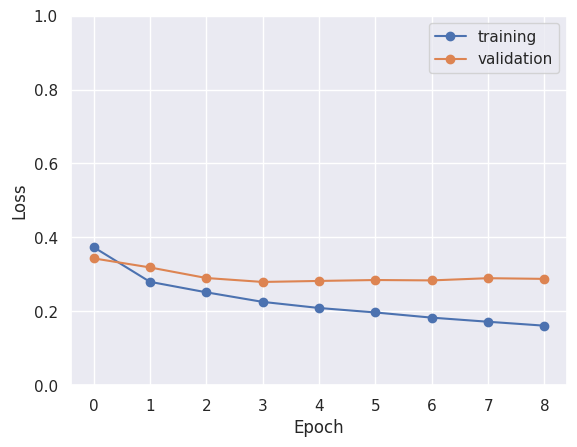

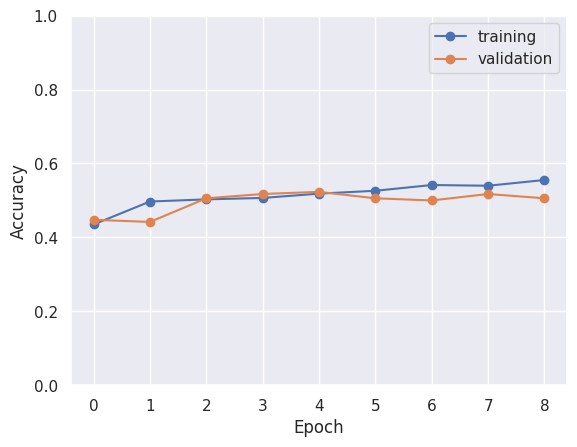

In [ ]:
plot_history(pd.DataFrame(history_cnn_learned.history))
plot_history(pd.DataFrame(history_cnn_learned.history), "accuracy")

In [ ]:
X_tfidf_train_3d = X_tfidf_full_train[..., np.newaxis]
X_tfidf_val_3d = X_tfidf_full_val[..., np.newaxis]
X_tfidf_test_3d = X_tfidf_full_test[..., np.newaxis]

print(f"X training (tf-idf) shape: { X_tfidf_train_3d.shape }")
print(f"X validation (tf-idf) shape: { X_tfidf_val_3d.shape }")
print(f"X testing (tf-idf) shape: { X_tfidf_test_3d.shape }")

X training (tf-idf) shape: (515, 1000, 1)
X validation (tf-idf) shape: (172, 1000, 1)
X testing (tf-idf) shape: (172, 1000, 1)


In [ ]:
tuner_cnn_tfidf = Hyperband(
    lambda hp: build_cnn(hp, X_tfidf_train_3d.shape),
    objective='val_loss',
    overwrite=True,
    max_epochs=20,
    factor=3,
    directory='cnn_tuning_tfidf',
    project_name='cnn_tuning'
)

tuner_cnn_tfidf.search(
    X_tfidf_train_3d,
    y_train,
    validation_data=(X_tfidf_val_3d, y_val),
    epochs=20,
    callbacks=[early_stopping]
)

Trial 30 Complete [00h 00m 27s]
val_loss: 0.34850817918777466

Best val_loss So Far: 0.2420036345720291
Total elapsed time: 00h 06m 39s


In [ ]:
model_cnn_tfidf = tuner_cnn_tfidf.hypermodel.build(tuner_cnn_tfidf.get_best_hyperparameters()[0])
print(model_cnn_tfidf.summary())

history_cnn_tfidf = model_cnn_tfidf.fit(
    X_tfidf_train_3d,
    y_train,
    epochs=20,
    validation_data=(X_tfidf_val_3d, y_val),
    callbacks=[early_stopping]
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 997, 24)        │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 332, 24)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 332, 24)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 7968)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │        63,752 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,872 (249.50 KB)

 Trainable params: 63,872 (249.50 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6008 - loss: 0.5117 - val_accuracy: 0.6453 - val_loss: 0.3542
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7146 - loss: 0.3134 - val_accuracy: 0.6628 - val_loss: 0.3396
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7142 - loss: 0.2925 - val_accuracy: 0.6802 - val_loss: 0.3219
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6977 - loss: 0.2752 - val_accuracy: 0.6860 - val_loss: 0.3084
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6692 - loss: 0.2545 - val_accuracy: 0.6337 - val_loss: 0.2925
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6492 - loss: 0.2288 - val_accuracy: 0.6163 - val_loss: 0.2764
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6537 - loss: 0.2015 - val_accuracy: 0.6105 - val_loss: 0.2615
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6656 - loss: 0.1760 - val_accuracy: 0.604

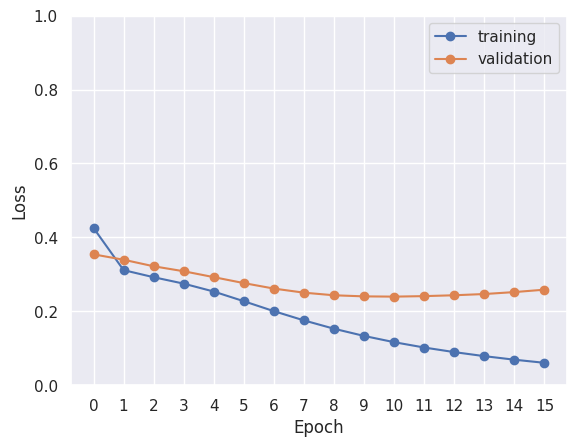

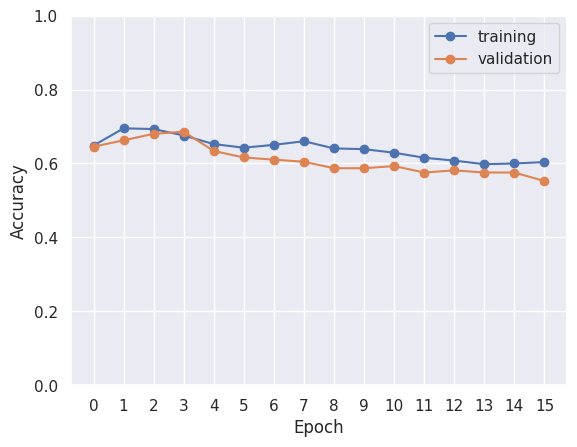

In [ ]:
plot_history(pd.DataFrame(history_cnn_tfidf.history))
plot_history(pd.DataFrame(history_cnn_tfidf.history), "accuracy")

In [ ]:
trials_cnn_tfidf = []
for trial in tuner_cnn_tfidf.oracle.get_best_trials(50):
    trial_dict = trial.hyperparameters.values
    trial_dict["val_loss"] = trial.score
    trials_cnn_tfidf.append(trial_dict)

df_trials_cnn_tfidf = pd.DataFrame(trials_cnn_tfidf)
df_trials_cnn_tfidf

conv_rounds  num_filters_0  kernel_size_0  pool_size_0  dropout_0  \
0             1             24              4            3        0.0   
1             1             40              2            4        0.2   
2             1             32              5            2        0.0   
3             1             32              5            2        0.0   
4             2             64              2            2        0.0   
5             2             64              2            2        0.0   
6             1             24              4            3        0.0   
7             1             56              3            5        0.2   
8             1             56              3            5        0.2   
9             1             32              3            5        0.1   
10            1             32              3            5        0.1   
11            3             24              5            4        0.1   
12            2             56              5            5        0.2   
13            3             48              2            2        0.3   
14            2             64              2            2        0.0   
15            1             56              3            5        0.2   
16            3             40              3            4        0.3   
17            3             48              2            2        0.3   
18            3             48              2            3        0.3   
19            1             24              4            2        0.4   
20            3             40              3            3        0.3   
21            2             24              5            5        0.2   
22            2             64              4            5        0.0   
23            3             64              3            2        0.4   
24            2             24              4            4        0.2   
25            2             64              5            3        0.2   
26            3             40              3            3        0.3   
27            3             48              5            4        0.1   
28            2             56              2            4        0.3   
29            1             24              4            5        0.2   

    hidden_layers  learning_rate  num_filters_1  kernel_size_1  pool_size_1  \
0               0       0.002902             56              5            3   
1               0       0.002332             64              4            2   
2               3       0.001085             16              3            5   
3               3       0.001085             16              3            5   
4               1       0.007709             16              2            2   
5               1       0.007709             16              2            2   
6               0       0.002902             56              5            3   
7               2       0.000724             16              3            2   
8               2       0.000724             16              3            2   
9               1       0.007020             56              3            3   
10              1       0.007020             56              3            3   
11              3       0.001109             48              3            3   
12              2       0.000162             32              2            5   
13              0       0.006532             48              5            4   
14              1       0.007709             16              2            2   
15              2       0.000724             16              3            2   
16              3       0.002963             24              5            5   
17              0       0.006532             48              5            4   
18              3       0.000850             24              4            4   
19              2       0.000279             32              3            5   
20              1       0.000633             48              4            2   
21

In [ ]:
interesting_params = [
    "conv_rounds", "num_filters_0", "hidden_layers", "neurons_0", "val_loss"
]
df_trials_cnn_tfidf[interesting_params].head(10)

conv_rounds  num_filters_0  hidden_layers  neurons_0  val_loss
0            1             24              0        128  0.242004
1            1             40              0        128  0.242127
2            1             32              3        192  0.257978
3            1             32              3        192  0.259806
4            2             64              1         64  0.261141
5            2             64              1         64  0.262873
6            1             24              0        128  0.267287
7            1             56              2        320  0.272575
8            1             56              2        320  0.275332
9            1             32              1        512  0.280183

# Experiments

### Hyperparameter Tuning - Multi-Label Logistic Regression

Training model with learning rate: 0.001
Training model with learning rate: 0.01
Training model with learning rate: 0.1
Training model with learning rate: 0.5
Training model with learning rate: 1.0


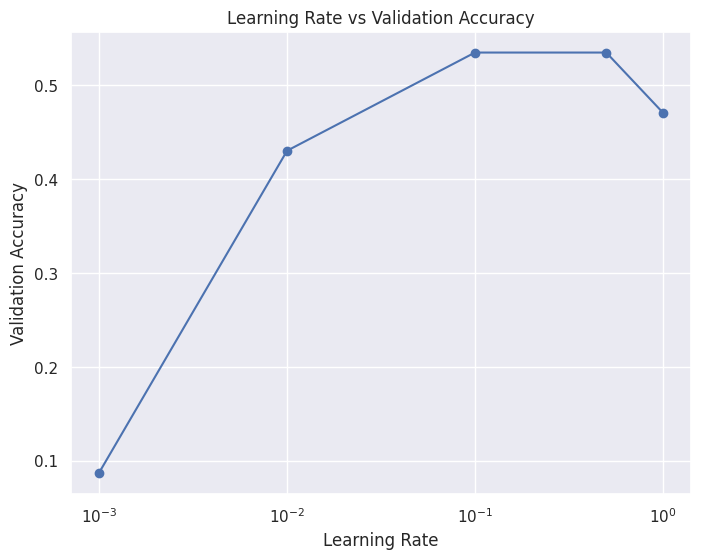

Learning Rate: 0.001 - Validation Accuracy: 0.0872
Learning Rate: 0.01 - Validation Accuracy: 0.4302
Learning Rate: 0.1 - Validation Accuracy: 0.5349
Learning Rate: 0.5 - Validation Accuracy: 0.5349
Learning Rate: 1.0 - Validation Accuracy: 0.4709


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Clear any previous sessions
tf.keras.backend.clear_session()

# Define a list of learning rates to test
learning_rates = [0.001, 0.01, 0.1, 0.5, 1.0]

# Store the results
results = []

# Iterate over the learning rates and train the model
for lr in learning_rates:
    print(f"Training model with learning rate: {lr}")

    # Define the model
    model_tf = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_tfidf_train.shape[1],)),
        tf.keras.layers.Dense(units=num_labels, activation='sigmoid')
    ])

    # Compile the model with the current learning rate
    model_tf.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=['accuracy']
    )

    # Fit the model
    history = model_tf.fit(
        X_tfidf_train,
        y_train,
        validation_data=(X_tfidf_val, y_val),
        epochs=10,
        batch_size=32,
        verbose=0  # To suppress verbose output
    )

    # Extract the accuracy of the validation set after training
    val_accuracy = history.history['val_accuracy'][-1]  # Last epoch validation accuracy
    results.append((lr, val_accuracy))

# Convert results to a NumPy array for easy plotting
results = np.array(results)

# Plot the learning rate vs validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(results[:, 0], results[:, 1], marker='o', linestyle='-', color='b')
plt.title("Learning Rate vs Validation Accuracy")
plt.xlabel("Learning Rate")
plt.ylabel("Validation Accuracy")
plt.xscale('log')  # Use log scale for better visualization
plt.grid(True)
plt.show()

# Print the results
for lr, acc in results:
    print(f"Learning Rate: {lr} - Validation Accuracy: {acc:.4f}")


### Hyperparameter tuning - FFNN

In [ ]:
trials_cnn_tfidf = []
for trial in tuner.oracle.get_best_trials(50):
    trial_dict = trial.hyperparameters.values
    trial_dict["val_loss"] = trial.score
    trials_cnn_tfidf.append(trial_dict)
df_trials_cnn_tfidf = pd.DataFrame(trials_cnn_tfidf)
df_trials_cnn_tfidf

learning_rate  val_loss
0       0.000214  0.587209
1       0.000200  0.430233
2       0.003150  0.261628

### Hyperparameter Tuning - Support Vector Machines

In [ ]:
hyperparameter_C = [0.1, 1]
hyperparameter_kernel = ['linear', 'rbf', 'sigmoid']
hyperparameter_gamma = ['scale', 'auto']

**NOTE** Running this Gridsearch will take several hours. Please Observe the table below for results.

In [ ]:
def gridsearch_svm(X_train, y_train, X_val, y_val, hyperparameter_C, hyperparameter_kernel, hyperparameter_gamma, random_state, verbose):
  best_ovr_classifier = None
  best_val_accuracies = []
  best_train_accuracies = []
  best_train_sizes = []
  for C in hyperparameter_C:
    for kernel in hyperparameter_kernel:
        for gamma in hyperparameter_gamma:
            if verbose == 1:
                print(f"[SVM Classifier]: Starting: C: {C}, Kernel: {kernel}, Gamma: {gamma} ")
            svm_classifier = SVC(kernel=kernel, C=C, gamma=gamma, probability=False, random_state=random_state)
            ovr_classifier = OneVsRestClassifier(svm_classifier, n_jobs=-1)
            train_accuracies, val_accuracies, train_sizes = train_svm(
                ovr_classifier=ovr_classifier,
                X_train=X_train,
                y_train=y_train,
                X_val=X_val,
                y_val=y_val
            )
            if verbose == 1:
              print(f"[SVM Classifier]: C: {C}, Kernel: {kernel}, Gamma: {gamma}, Training Accuracy: {train_accuracies[-1]}, Val Accuracy: {val_accuracies[-1]} ")
            if best_ovr_classifier is None or val_accuracies[-1] > best_val_accuracy[-1]:
                best_ovr_classifier = ovr_classifier
                best_val_accuracy = val_accuracies
                best_train_accuracy = train_accuracies
                best_train_sizes = train_sizes
  return best_ovr_classifier, best_train_accuracy, best_val_accuracy, best_train_sizes

In [ ]:
best_ovr_classifier, best_train_accuracy, best_val_accuracy, best_train_sizes = gridsearch_svm(
    X_train=X_learned_embeddings_train_2D,
    y_train=y_train,
    X_val=X_learned_embeddings_val_2D,
    y_val=y_val,
    hyperparameter_C=hyperparameter_C,
    hyperparameter_kernel=hyperparameter_kernel,
    hyperparameter_gamma=hyperparameter_gamma,
    random_state=1234,
    verbose=0
  )

| C   | Kernel  | Gamma   | Training Accuracy | Validation Accuracy |
|-----|---------|---------|-------------------|---------------------|
| 0.1 | linear  | scale   | 0.9320            | 0.3605              |
| 0.1 | linear  | auto    | 0.9320            | 0.3605              |
| 0.1 | rbf     | scale   | 0.4155            | 0.3779              |
| 0.1 | rbf     | auto    | 0.4155            | 0.3779              |
| 0.1 | sigmoid | scale   | 0.4155            | 0.3779              |
| 0.1 | sigmoid | auto    | 0.4155            | 0.3779              |
| 1   | linear  | scale   | 0.9961            | 0.2965              |
| 1   | linear  | auto    | 0.9961            | 0.2965              |
| 1   | rbf     | scale   | 0.4194            | 0.3837              |
| 1   | rbf     | auto    | 0.4194            | 0.3837              |
| 1   | sigmoid | scale   | 0.4194            | 0.3895              |
| 1   | sigmoid | auto    | 0.4194            | 0.3895              |

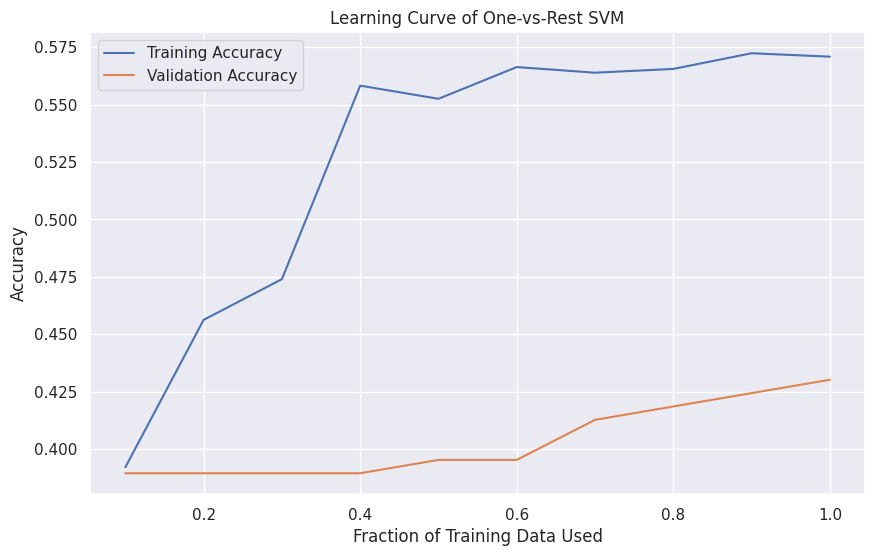

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(best_train_sizes, best_train_accuracy, label='Training Accuracy')
plt.plot(best_train_sizes, best_val_accuracy, label='Validation Accuracy')
plt.title('Learning Curve of One-vs-Rest SVM')
plt.xlabel('Fraction of Training Data Used')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation & Generalization

### Baseline

In [ ]:
import sklearn.metrics as mt

print("Accuracy:", mt.accuracy_score(y_test, np.zeros(y_test.shape)))
print("Recall:", mt.f1_score(y_test, np.zeros(y_test.shape), average="macro"))
print("AUPRC:", mt.average_precision_score(y_test, np.zeros(y_test.shape), average="macro"))

Accuracy: 0.3372093023255814
Recall: 0.0
AUPRC: 0.12209302325581396


### Multi-label logistic regression

In [ ]:
y_test_probs = model_lr.predict(X_tfidf_test)

# Applying a fixed threshold
threshold = 0.2
y_test_pred_lr = (y_test_probs >= threshold).astype(int)
print("Accuracy:", accuracy_score(y_test, y_test_pred_lr))
print("Recall:", f1_score(y_test, y_test_pred_lr, average="micro"))
print("AUPRC:", average_precision_score(y_test, y_test_pred_lr, average="micro"))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Accuracy: 0.313953488372093
Recall: 0.14492753623188406
AUPRC: 0.1455325198057756


### FFNN

In [ ]:
y_test_probs_ffnn = model.predict(X_learned_embeddings_test)

# Applying a fixed threshold
threshold = 0.29
y_test_pred_ffnn = (y_test_probs_ffnn >= threshold).astype(int)
print("Accuracy:", accuracy_score(y_test, y_test_pred_ffnn))
print("Micro Recall:", f1_score(y_test, y_test_pred_ffnn, average="micro"))
print("Micro AUPRC:", average_precision_score(y_test, y_test_pred_ffnn, average="micro"))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Accuracy: 0.43023255813953487
Micro Recall: 0.4444444444444444
Micro AUPRC: 0.30361757105943155


### SVM

In [ ]:
y_test_pred = best_ovr_classifier.predict(X_learned_embeddings_test_2D)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.4070


In [ ]:
precision_micro = precision_score(y_test, y_test_pred, average='micro')
recall_micro = recall_score(y_test, y_test_pred, average='micro')
f1_micro = f1_score(y_test, y_test_pred, average='micro')

print(f"Micro-averaged Precision: {precision_micro:.4f}")
print(f"Micro-averaged Recall: {recall_micro:.4f}")
print(f"Micro-averaged F1-Score: {f1_micro:.4f}")
# AUPRC (Area Under the Precision-Recall Curve) - requires probabilities
auprc = average_precision_score(y_test, y_test_pred, average='micro')
print(f"Micro-averaged AUPRC: {auprc:.4f}")

# Hamming Loss
hamming = hamming_loss(y_test, y_test_pred)
print(f"Hamming Loss: {hamming:.4f}")


Micro-averaged Precision: 0.8889
Micro-averaged Recall: 0.1905
Micro-averaged F1-Score: 0.3137
Micro-averaged AUPRC: 0.2681
Hamming Loss: 0.1017


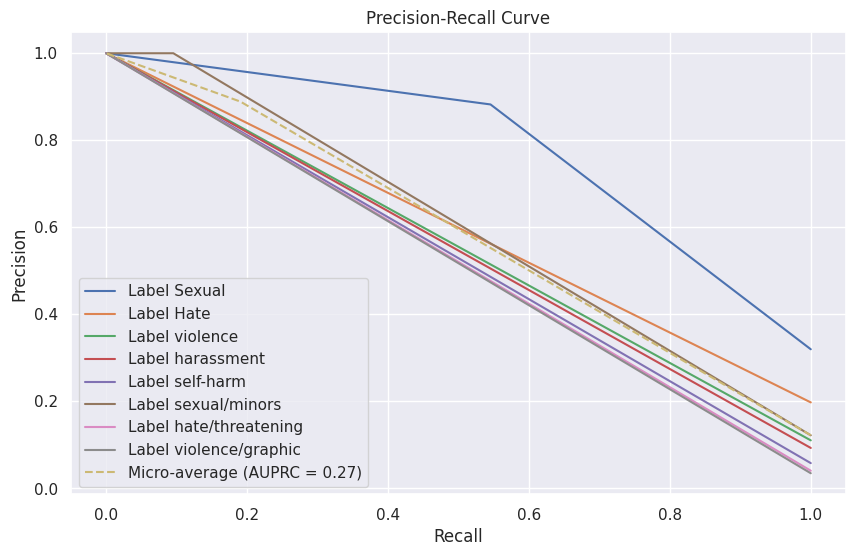

In [ ]:
# For each individual label
plt.figure(figsize=(10, 6))
for i in range(num_labels):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_test_pred[:, i])
    plt.plot(recall, precision, label=f'Label {labels[i]}')

# Micro-averaged Precision-Recall curve
precision_micro_curve, recall_micro_curve, _ = precision_recall_curve(y_test.ravel(), y_test_pred.ravel())
auprc_micro = average_precision_score(y_test, y_test_pred, average='micro')
plt.plot(recall_micro_curve, precision_micro_curve, label=f'Micro-average (AUPRC = {auprc_micro:.2f})', linestyle='--')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

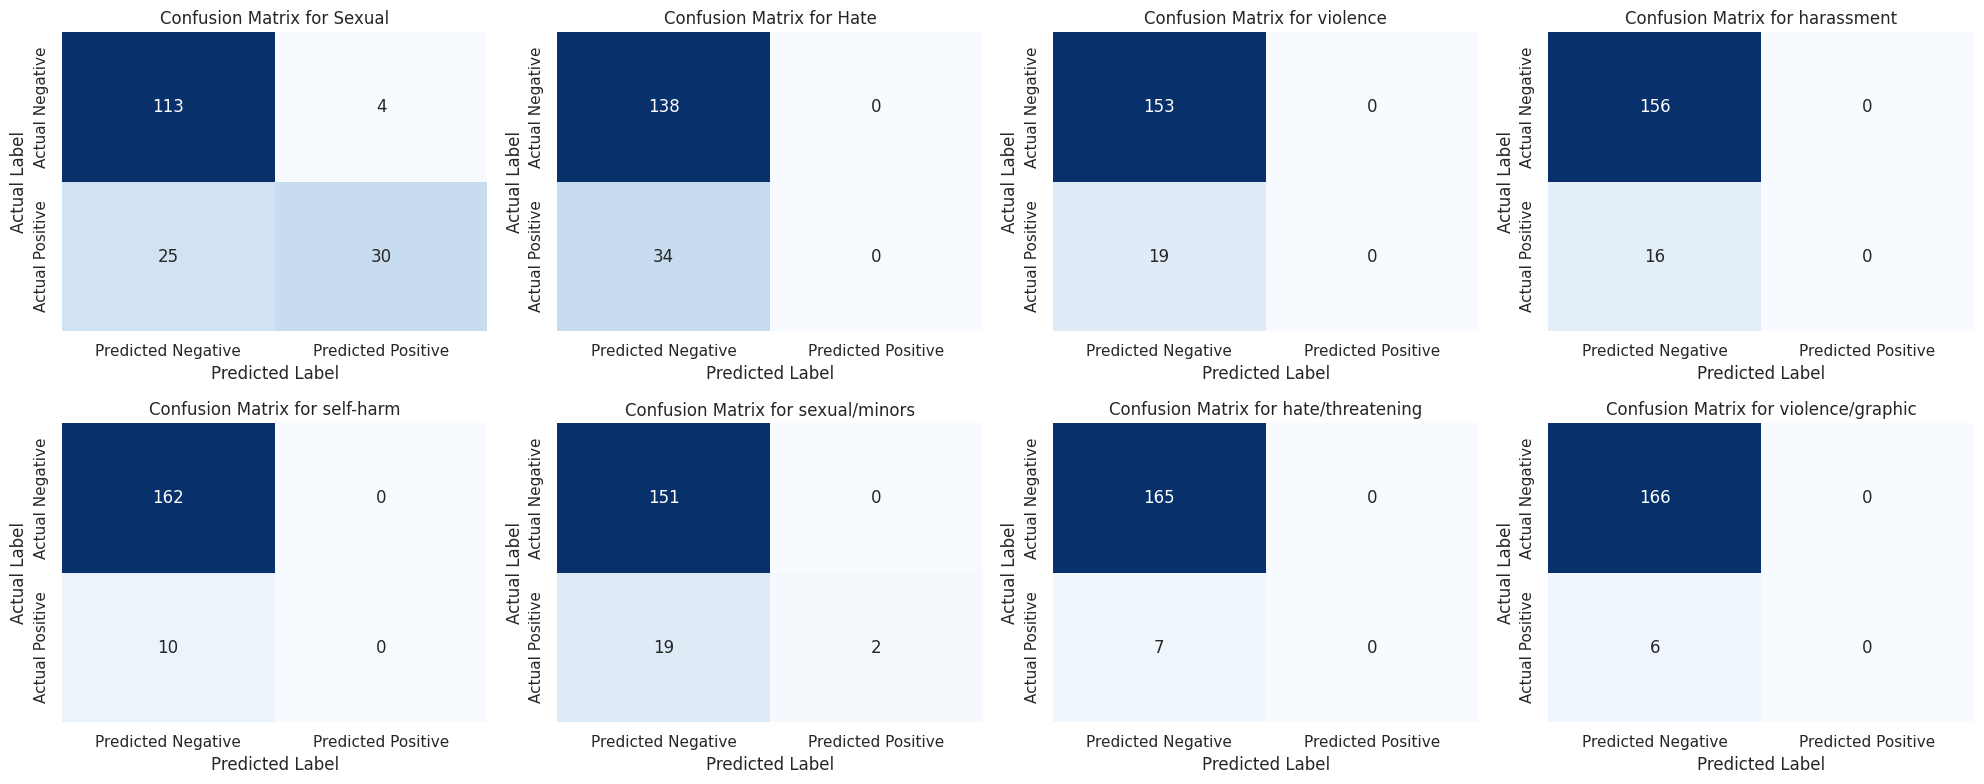

In [ ]:
# Generate the multi-label confusion matrix
multi_label_matrix = multilabel_confusion_matrix(y_test, y_test_pred)
num_labels = multi_label_matrix.shape[0]
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()

class_labels = [f'{labels[i]}' for i in range(num_labels)]

for i, matrix in enumerate(multi_label_matrix):
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'],
                ax=axes[i])
    axes[i].set_title(f'Confusion Matrix for {class_labels[i]}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('Actual Label')

plt.tight_layout()
plt.show()

### CNN

In [ ]:
y_test_pred_cnn_tfidf = np.round(model_cnn_tfidf.predict(X_tfidf_test_3d))

print("Accuracy:", mt.accuracy_score(y_test, y_test_pred_cnn_tfidf))
print("Recall:", mt.f1_score(y_test, y_test_pred_cnn_tfidf, average="micro"))
print("AUPRC:", mt.average_precision_score(y_test, y_test_pred_cnn_tfidf, average="micro"))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Accuracy: 0.45348837209302323
Recall: 0.5107913669064749
AUPRC: 0.3432755713278969


# Fairness

A critical challenge in developing models is the assurance of fairness and mitigation of bias, particularly in the context of content moderation. Like other NLP models, our content moderation models likely do suffer from biases towards certain demographic attributes. These biases arise from the inherent biases present in the internet data used for training, where societal biases can manifest explicitly or implicitly.

# Discussion

Our research evaluated the effectiveness of various multi-label classification models on the OpenAI Content Moderation dataset, aiming to answer the central question:
"How effectively can multi-label classifiers, trained on a dataset of prompts sent to LLMs, accurately identify and categorize multiple unsafe content labels?"

The dataset comprises 1,680 text prompts, each labeled with binary flags across 8 categories of unsafe content (e.g., sexual, hate, violence, harassment). These categories reflect critical safety and ethical concerns in generative AI deployments.

The CNN model emerged as the top performer, achieving the highest scores across all three metrics—Accuracy (0.453), Recall (0.510), and AUPRC (0.359). This suggests CNNs are particularly effective at capturing patterns in text representations that indicate unsafe content.

Feed-forward neural networks also demonstrated strong performance (AUPRC: 0.304), significantly outperforming both the baseline and logistic regression, highlighting the value of non-linear modeling for this task.

Traditional models like SVMs and logistic regression lagged behind, particularly in recall, implying that they struggle to capture the diversity and complexity of unsafe content across multiple categories.

Conclusion:
As generative language models become more widespread, the ability to proactively detect and classify unsafe content is both a technical and ethical imperative. Our results reinforce that multi-label deep learning models—particularly CNNs—are more effective than linear baselines for this task. Their improved performance in both recall and AUPRC is essential for minimizing harm, maintaining user trust, and ensuring regulatory compliance.